In [1]:
%load_ext autoreload
%autoreload 2
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from keras_tqdm import TQDMNotebookCallback as ktqdm
from tqdm import tqdm_notebook as tqdm

from matplotlib import pyplot as plt
from imblearn.keras import BalancedBatchGenerator
from keras import backend as B
from sklearn.metrics import roc_auc_score

from  plot_keras_history import plot_history
import extra_keras_metrics

def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    B.get_session().run(tf.local_variables_initializer())
    return auc

#def auroc(y_true, y_pred):
#    return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)

def plot_history_graph(history, index, label):
    """Plot the graph for the given history metrics."""
    plt.plot(history.history[index], label='Training %s = %0.6f' % (label, history.history[index][-1]))
    plt.plot(history.history['val_%s'%index] , label='Testing %s = %0.6f' % (label, history.history['val_%s'%index][-1]))
    plt.title('Model %s'%label, fontsize=15)
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.legend(loc='upper right')
    

def build_model(input_neurons):
    model = Sequential()
    model.add(Dense(32, input_dim=input_neurons, name="Input_dense_layer", activation="sigmoid"))
    model.add(BatchNormalization())
    model.add(Dense(16, name="Second_hidden_layer", activation="sigmoid"))
    model.add(BatchNormalization())
    model.add(Dense(1, name="Output_layer", activation="sigmoid"))
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=['accuracy', 'auroc', 'auprc'])
    return model

Using TensorFlow backend.


In [2]:
path_classes = "/home/tore/venv/Bioinfo_files/HepG2_class.csv"
path_epigenomic = "/home/tore/venv/Bioinfo_files/HepG2_ep_data.csv"

labels = pd.read_csv(path_classes, names = ["Label"])
epigenomic = pd.read_csv(path_epigenomic, sep=",")

data = (labels.join(epigenomic)).drop("Unnamed: 0", axis=1)
data = data[(data.Label == "A-E") | (data.Label == "I-E")]

data['Label'] = data['Label'].map({'A-E': 1, 'I-E': 0})

In [3]:
x_set = data.values[:, data.columns != "Label"]
y_set = data.values[:, data.columns == "Label"]

/usr/local/lib/python3.6/dist-packages/scipy/signal/_arraytools.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  b = a[a_slice]


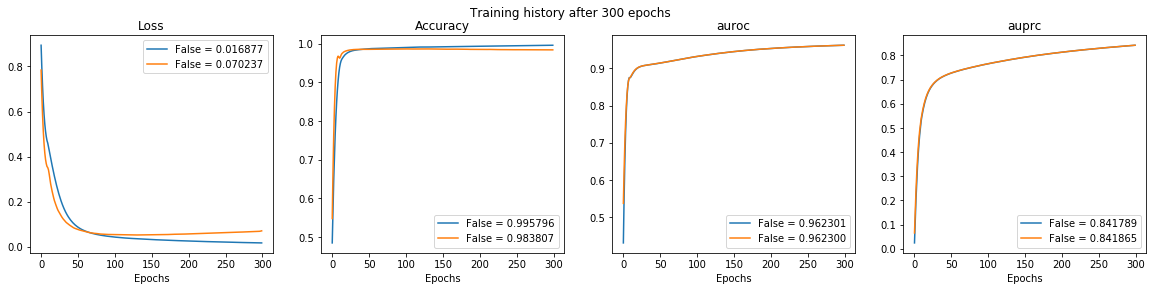

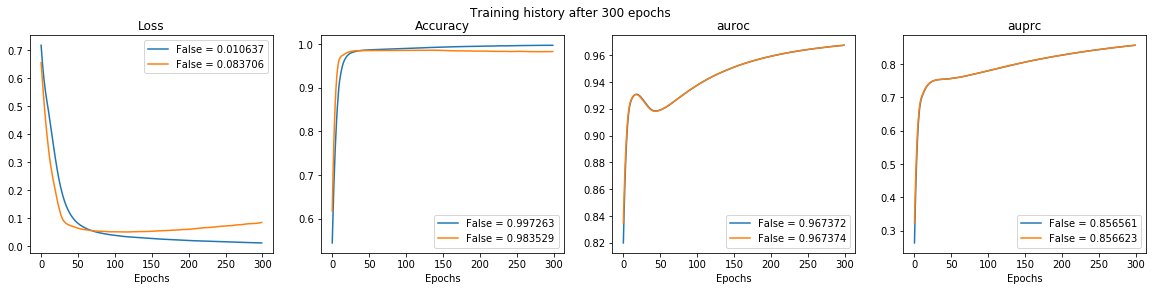

KeyboardInterrupt: 

In [4]:
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(25)
random.seed(25)
tf.set_random_seed(25)

l_history = []
l_model=[]
for i in range(10):
    x_train, x_test, y_train, y_test = train_test_split(
        x_set,
        y_set,
        test_size=0.3,
        random_state=42,
        shuffle=True)
    model = build_model(x_train.shape[1])
    l_model.append(model)
    l_history.append(
        model.fit(
            x_train,
            y_train,
            epochs=300,
            shuffle=True,
            batch_size=4096,
            verbose=0,
            callbacks=[ktqdm(metric_format="{name}: {value:e}")],
            validation_data=(x_test, y_test)
        ).history
    )
    plot_history(l_history[i])
    plt.show()
    B.clear_session()

for history in l_history:
    plt.figure(figsize=(20,10))
    plt.subplot(1,2,1)
    plot_history_graph(history, "acc", "accuracy")
    plt.subplot(1,2,2)
    plot_history_graph(history, "loss", "loss")
    plt.show()

In [ ]:
plot_history(l_history[0])